

## **Modelo de Regressão para Precificação de Veículos**

Nesta etapa, vamos desenvolver um **modelo de regressão** para estimar o **preço dos veículos** com base nas características coletadas e transformadas ao longo do projeto, incluindo os insights obtidos na etapa de **clustering**. O objetivo é construir uma ferramenta que permita **prever preços de forma precisa**, considerando tanto atributos numéricos quanto categóricos dos carros.

A análise de regressão nos permitirá:

1. **Quantificar a influência de cada variável** sobre o preço do veículo, identificando fatores determinantes como idade, quilometragem, avaliações de motoristas e características do carro (tipo de transmissão, drivetrain, fabricante, etc.).
2. **Gerar previsões confiáveis** para novos veículos, facilitando decisões de compra, venda ou avaliação de mercado.
3. **Integrar informações de clusters** para entender melhor segmentos de carros e melhorar a acurácia do modelo, permitindo ajustes de preço mais realistas para cada grupo.

Antes de treinar o modelo, realizamos **pré-processamento dos dados**:

* Seleção das variáveis mais relevantes com base em análises exploratórias e clustering.
* Normalização e padronização das variáveis numéricas para evitar que escalas diferentes distorçam o modelo.
* Codificação adequada das variáveis categóricas (One-Hot Encoding ou técnicas similares).
* Tratamento de valores faltantes.

Para o desenvolvimento do modelo, consideraremos:

* **Modelos de regressão linear e regularizada (Ridge, Lasso)** para capturar relações lineares e controlar overfitting.
* **Modelos de ensemble, como Gradient Boosting ou Random Forest**, que podem capturar interações complexas entre as variáveis e fornecer previsões mais robustas.
* **Validação cruzada e métricas de desempenho**, como RMSE, MAE e R², para avaliar a precisão e generalização do modelo.

Ao final desta etapa, teremos um **modelo de precificação confiável**, capaz de estimar o valor de um veículo com base em seus atributos, proporcionando **insights acionáveis para vendas, avaliação de mercado e tomada de decisões estratégicas**.




In [31]:
#Manipulação dos dados
import pandas as pd
import numpy as np

#Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns


#Pre processamento dos dados
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer


#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Métricas de avaliação do modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Divisão de traino e validação
from sklearn.model_selection import train_test_split

#Selecionar as melhores features
from sklearn.feature_selection import SelectKBest, f_classif,SelectFromModel, f_regression

#Modelos a serem testados
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#Tunagem dos hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV

#Validação crusada
from sklearn.model_selection import cross_validate, KFold

In [32]:
train = pd.read_csv("../Dados/used_car_train.csv", index_col=0)
test = pd.read_csv("../Dados/used_car_test.csv", index_col = 0)

train.head()

,manufacturer,year,mileage,mpg,accidents_or_damage,one_owner,personal_use_only,driver_rating,driver_reviews_num,price,transmission_simple,color_exterior_simple,color_interior_simple,drivetrain_simple,fuel_type_simple,cluster
561046,Nissan,2022,7963.0,19.5,0.0,1.0,1.0,4.2,19.0,35693.0,Automatic,red,black,4WD,Gasoline,Carros Luxos/Valorizados
390497,Jeep,2017,65998.0,21.5,0.0,0.0,1.0,4.8,335.0,22999.0,Automatic,white,black,4WD,Gasoline,Carros Custo-Benefício
13707,Other,2017,50986.0,29.0,0.0,0.0,1.0,4.8,90.0,23900.0,Manual,black,black,FWD,Gasoline,Carros Premium
576420,Nissan,2018,74244.0,28.5,0.0,0.0,0.0,4.7,417.0,18988.0,Automatic,black,black,AWD,Gasoline,Carros Custo-Benefício
247684,Ford,2021,18908.0,23.5,0.0,0.0,0.0,4.8,31.0,34189.0,Automatic,gray,black,RWD,Gasoline,Carros Premium


Agora com os dados em mãos, dividir em features e em target e depois separar os dados de validação.

In [33]:
X_ = train.drop(columns=["price"], axis=1)
y_ = train["price"]

X_test = test.drop(columns=["price"], axis=1)
y_test = test["price"]

X_train, X_validacao, y_train, y_validacao = train_test_split(X_, y_, test_size=0.3, stratify=X_["cluster"], random_state=42)


In [4]:
print(f"O dataset de treino apresenta {X_train.shape[0]} linhas e {X_train.shape[1]} colunas")
print(f"O dataset de validação apresenta {X_validacao.shape[0]} linhas e {X_validacao.shape[1]} colunas")
print(f"O dataset de teste apresenta {X_test.shape[0]} linhas e {X_test.shape[1]} colunas")


O dataset de treino apresenta 343511 linhas e 15 colunas
O dataset de validação apresenta 147219 linhas e 15 colunas
O dataset de teste apresenta 150590 linhas e 15 colunas


In [5]:
print(f"O dataset de treino apresenta {y_train.shape[0]} linhas")
print(f"O dataset de validação apresenta {y_validacao.shape[0]} linhas")
print(f"O dataset de teste apresenta {y_test.shape[0]} linhas")

O dataset de treino apresenta 343511 linhas
O dataset de validação apresenta 147219 linhas
O dataset de teste apresenta 150590 linhas


Agora com os dados prontos eu posso começar a criar o pipeline de transformação dos dados para os modelos receberem os dados no formato certo!

In [6]:

colunas_numericas = X_train.select_dtypes(include="number").columns
colunas_categoricas = X_train.select_dtypes(include = "object").columns

#Pipeline de tranformações das features numéricas
transformacao_colunas_numericas_mlineares = Pipeline(
    steps=[
        ("preencher_num", SimpleImputer(strategy="median")),
       ( "escalar", RobustScaler())
    ]
)
transformacao_colunas_numericas_arvores = Pipeline(
    steps=[
        ("preencher_num", SimpleImputer(strategy="median")),
    ]
)

#Pipeline de tranformações das features categoricas
transformacao_colunas_categoricas=Pipeline(
    steps=[
        ("preencher_cat", SimpleImputer(strategy="most_frequent")),
        ("variaveis_cat", ce.TargetEncoder())
    ]
)


#Transformadores das colunas numericas e categoricas
processador_linear = ColumnTransformer(
    transformers=[
        ("num", transformacao_colunas_numericas_mlineares, colunas_numericas),
        ("cat", transformacao_colunas_categoricas, colunas_categoricas)
    ]
)
processador_arvores = ColumnTransformer(
    transformers=[
        ("num", transformacao_colunas_numericas_arvores, colunas_numericas),
        ("cat", transformacao_colunas_categoricas, colunas_categoricas)
    ]
)

Com os pipelines feitos irei partir para a avaliação dos modelos baseline

### **Avaliação dos Modelos Baseline**

Nesta etapa irei avaliar os modelos sem nenhum hiperparâmetro, os que se sairem melhores vão ser os modelos base line para passar pelo processo de tunagem do modelo por meio de RandomSearchCV

In [7]:
modelos_regressao = [
    ("Decision Tree Regressor", DecisionTreeRegressor(random_state=42)),
    ("XGBoost Regressor", XGBRegressor(eval_metric='rmse', random_state = 42)),
    ("LGBM Regressor", LGBMRegressor(random_state=42)),
    
]


# Dicionário para armazenar resultados
resultados = {}

# Loop para treinar e avaliar cada modelo
for nome, modelo in modelos_regressao:
    # Pipeline com pré-processamento + modelo
    pipe = Pipeline(steps=[
        ("preprocessador", processador_arvores),
        ("modelo", modelo)
    ])
    
    # Treinamento
    pipe.fit(X_train, y_train)
    
    # Predição
    y_pred = pipe.predict(X_validacao)
    
    # Cálculo de métricas para regressão
    mse = mean_squared_error(y_validacao, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_validacao, y_pred)
    r2 = r2_score(y_validacao, y_pred)

    resultados[nome] = {
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }

# Mostrar resultados c
for nome, metricas in resultados.items():
    print(f"{nome}: R2={metricas['R2']:.3f}, MSE={metricas['MSE']:.3f}, RMSE={metricas['RMSE']:.3f}, MAE={metricas['MAE']:.3f}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 343511, number of used features: 15
[LightGBM] [Info] Start training from score 29850.664206
Decision Tree Regressor: R2=0.695, MSE=142681427.871, RMSE=11944.933, MAE=3754.048
XGBoost Regressor: R2=0.807, MSE=89981883.635, RMSE=9485.878, MAE=3595.184
LGBM Regressor: R2=0.779, MSE=103085866.330, RMSE=10153.121, MAE=4163.556


c:\Users\rianf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
modelos_regressao = [
    ("Lasso", Lasso()),
    ("Ridge", Ridge()),
    ("Linear Regression", LinearRegression()),
    ("Gradient Boosting Regressor", GradientBoostingRegressor())
]



# Dicionário para armazenar resultados
resultados = {}

# Loop para treinar e avaliar cada modelo
for nome, modelo in modelos_regressao:
    # Pipeline com pré-processamento + modelo
    pipe = Pipeline(steps=[
        ("preprocessador", processador_linear),
        ("feature_sel", SelectKBest(score_func=f_regression, k=5)),
        ("modelo", modelo)
    ])
    
    # Treinamento
    pipe.fit(X_train, y_train)
    
    # Predição
    y_pred = pipe.predict(X_validacao)
    
    # Cálculo de métricas para regressão
    mse = mean_squared_error(y_validacao, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_validacao, y_pred)
    r2 = r2_score(y_validacao, y_pred)

    resultados[nome] = {
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }

# Mostrar resultados c
for nome, metricas in resultados.items():
    print(f"{nome}: R2={metricas['R2']:.3f}, MSE={metricas['MSE']:.3f}, RMSE={metricas['RMSE']:.3f}, MAE={metricas['MAE']:.3f}")


Lasso: R2=0.327, MSE=314256944.323, RMSE=17727.294, MAE=8252.563
Ridge: R2=0.327, MSE=314256986.294, RMSE=17727.295, MAE=8252.734
Linear Regression: R2=0.327, MSE=314256977.130, RMSE=17727.295, MAE=8252.740
Gradient Boosting Regressor: R2=0.544, MSE=212938169.270, RMSE=14592.401, MAE=6310.771


Agora que eu tenho os melhores modelos que foram: Decision Tree, XGBoost, LGBM e Gradient Boosting. Irei começar um cross validation em todos eles e ver como eles se saem com não só uma parte dos dados, mas varias partes e depois isso iniciar a tunagem dos hiperparâmetros

In [9]:

def cross_validation_melhores_modelos(modelo, nome_modelo):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    pipe = Pipeline(steps=[
            ("preprocessador", processador_linear),
            ("modelo", modelo)
        ])
        

    scoring = {
        "R2": "r2",
        "MSE": "neg_mean_squared_error",
        "MAE": "neg_mean_absolute_error"
    }

    scores = cross_validate(pipe, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)

    print(nome_modelo)
    print("R2 médio:", np.mean(scores["test_R2"]))
    print("RMSE médio:", np.sqrt(-np.mean(scores["test_MSE"])))
    print("MAE médio:", -np.mean(scores["test_MAE"]))

cross_validation_melhores_modelos(XGBRegressor(), "XGBRegressor")
cross_validation_melhores_modelos(LGBMRegressor(), "LGBMRegressor")
cross_validation_melhores_modelos(DecisionTreeRegressor(), "DecisionTreeRegressor")

XGBRegressor
R2 médio: 0.8454087903934433
RMSE médio: 8057.120244263461
MAE médio: 3606.534634387435
LGBMRegressor
R2 médio: 0.8191967016119911
RMSE médio: 8716.101938644084
MAE médio: 4182.4753751633425
DecisionTreeRegressor
R2 médio: 0.7335691952280887
RMSE médio: 10561.123925218484
MAE médio: 3797.9243456831855


Aqui mostra que os modelos realmente se manteram com os mesmos resultados, o que indica que eles não se sairam só bem em um conjunto especifico mas sim em um conjunto geral. Agora fazer a tunagem dos hiperparâmetros e após isso ver qual modelo se saiu melhor.

In [10]:

def otimizar_modelo_regressao(modelo, pipe_preprocessador, param_distributions, cv=3, n_iter=20, scoring="neg_root_mean_squared_error", verbose=2, random_state=42):
    
    # Criar pipeline
    pipe = Pipeline(steps=[
        ("preprocessador", pipe_preprocessador),
        ("modelo", modelo)
    ])
    
    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=verbose,
        random_state=random_state
    )
    
    # Treinar
    search.fit(X_train, y_train)
    
    # Resultados
    best_rmse = -search.best_score_
    print(f"Melhores parâmetros para {modelo.__class__.__name__}: {search.best_params_}")
    print(f"Melhor RMSE: {best_rmse:.3f}\n")
    
    # Retorna o melhor modelo ajustado
    return search.best_estimator_


In [11]:
#Decision Tree
param_dt = {
    "modelo__max_depth": [3, 5, 7, 10, None],
    "modelo__min_samples_split": [2, 5, 10],
    "modelo__min_samples_leaf": [1, 2, 4]
}


melhor_decision_tree = otimizar_modelo_regressao(DecisionTreeRegressor(), processador_arvores, param_dt)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores parâmetros para DecisionTreeRegressor: {'modelo__min_samples_split': 10, 'modelo__min_samples_leaf': 2, 'modelo__max_depth': None}
Melhor RMSE: 9611.789



In [12]:
#LGBM
param_lgbm = {
    "modelo__n_estimators": [50, 100, 200],
    "modelo__max_depth": [3, 5, 7, -1],
    "modelo__learning_rate": [0.01, 0.05, 0.1],
    "modelo__num_leaves": [20, 31, 50],
    "modelo__subsample": [0.6, 0.8, 1.0],
    "modelo__colsample_bytree": [0.6, 0.8, 1.0]
}


melhor_lgbm = otimizar_modelo_regressao(LGBMRegressor(), processador_arvores, param_lgbm)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 343511, number of used features: 15
[LightGBM] [Info] Start training from score 29850.664206
Melhores parâmetros para LGBMRegressor: {'modelo__subsample': 0.8, 'modelo__num_leaves': 31, 'modelo__n_estimators': 200, 'modelo__max_depth': -1, 'modelo__learning_rate': 0.1, 'modelo__colsample_bytree': 1.0}
Melhor RMSE: 8253.046



In [13]:
#XGBoost
param_xgb = {
    "modelo__n_estimators": [50, 100, 200],
    "modelo__max_depth": [3, 5, 7],
    "modelo__learning_rate": [0.01, 0.05, 0.1],
    "modelo__subsample": [0.6, 0.8, 1.0],
    "modelo__colsample_bytree": [0.6, 0.8, 1.0]
}


melhor_xgb = otimizar_modelo_regressao(XGBRegressor(), processador_arvores, param_xgb)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores parâmetros para XGBRegressor: {'modelo__subsample': 1.0, 'modelo__n_estimators': 200, 'modelo__max_depth': 7, 'modelo__learning_rate': 0.1, 'modelo__colsample_bytree': 0.8}
Melhor RMSE: 7701.915




Observamos uma **melhora significativa no RMSE** após o ajuste dos modelos:

* **Decision Tree Regressor:** o RMSE passou de **10.748,36** para **9.593,88**
* **XGBoost Regressor:** o RMSE reduziu de **8.057,12** para **7.701,92**
* **LGBM Regressor:** o RMSE caiu de **8.716,10** para **8.253,05**

Esses resultados mostram que a **otimização dos hiperparâmetros** teve um impacto positivo na performance de todos os modelos. Apartir daqui irei utilizar o XGBoost pois trouce o melhor desempenho



In [37]:
def avaliacao_final(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    # Dicionário para armazenar resultados
    resultados = {}
    # Cálculo de métricas para regressão
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados["XGBoost"] = {
            "R2": r2,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae
        }

    # Mostrar resultados c
    for nome, metricas in resultados.items():
        print(f"{nome}: R2={metricas['R2']:.3f}, MSE={metricas['MSE']:.3f}, RMSE={metricas['RMSE']:.3f}, MAE={metricas['MAE']:.3f}")

In [38]:
avaliacao_final(melhor_xgb, X_test, y_test)

XGBoost: R2=0.000, MSE=6640633982607.661, RMSE=2576942.759, MAE=14959.120


Os resultdos foram pessímos nos dados de teste, irei análisar se foi por algum outlier expressivo ou porque o modelo realmente não está se comportando bem com os dados de teste

<Axes: ylabel='price'>

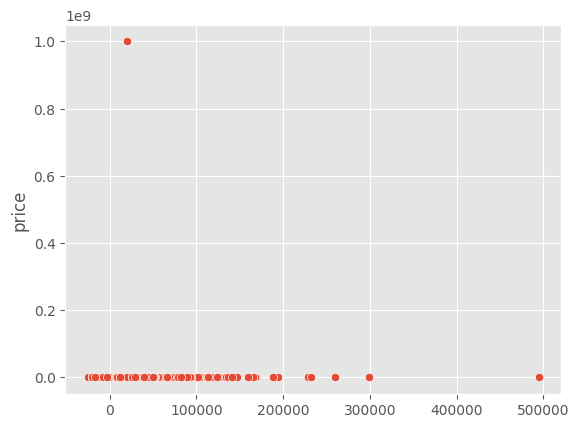

In [ ]:
sns.scatterplot(x=y_pred, y=y_test)

Identifiquei o problema: os dados de teste continham um outlier extremamente alto, de 1 bilhão, que não tratamos por boas práticas. Esse valor distorceu o resultado final. Irei removê-lo para avaliar como o modelo se comporta com os dados sem esse outlier, que dificilmente ocorreria em uma situação real.

In [40]:
test=test[test["price"]<1000000000]
X_test = test.drop(columns=["price"], axis=1)
y_test = test["price"]
avaliacao_final(melhor_xgb, X_test, y_test)


XGBoost: R2=0.421, MSE=352521478.973, RMSE=18775.555, MAE=8318.761




Na avaliação do modelo XGBoost, obtivemos os seguintes resultados no conjunto de teste: **R² = 0.421**, **MSE = 352.521.479**, **RMSE = 18.775,56** e **MAE = 8.318,76**. Esses valores indicam que o modelo consegue explicar cerca de 42% da variabilidade dos preços dos veículos, mostrando um desempenho moderado, mas ainda útil para estimativas e análises exploratórias de precificação.

Observou-se que o conjunto de teste continha um outlier extremamente elevado (1 bilhão), que não foi removido deliberadamente por boas práticas. Em situações reais, não é esperado que valores tão discrepantes ocorram; portanto, não é recomendada a remoção de outliers do conjunto de teste, pois isso poderia introduzir viés e sobreajuste ao modelo. Esse outlier impactou fortemente as métricas de erro, especialmente o RMSE, inflando o valor médio de erro quadrático.

Mesmo considerando esse ponto, o modelo apresenta **capacidade de captura de padrões relevantes**, refletida em erros médios (MAE) de aproximadamente 8.300, o que sugere que, para a maioria dos casos reais, o modelo fornece previsões consistentes e dentro de uma margem de erro aceitável. Para aplicações futuras, recomenda-se monitorar a presença de outliers e, se necessário, criar estratégias específicas para lidar com valores extremos sem comprometer a generalização do modelo.

Em resumo, o XGBoost se mostra robusto e apto para ser utilizado como ferramenta de previsão de preços, mas deve-se ter atenção especial a valores extremamente atípicos que não representem cenários reais.

